# Torch DQN on Gray Scale CT slice 

In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import gym


import time
import sys

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Choose the environment. 

pygame 2.1.2 (SDL 2.0.18, Python 3.7.12)
Hello from the pygame community. https://www.pygame.org/contribute.html
The path is actually set
New background Set!
set the target x to 82
set the target y to 47


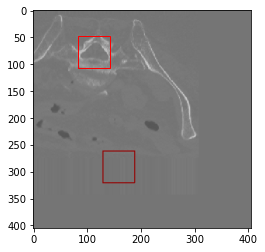

In [2]:
# # # Load a FOV grabber for pelvis. 
# import gym_child
# env = gym.make('maze-v0')
# environment_type = "thresholded"


# #This is the new distance metric reward function.
# import gym_teen
# env = gym.make('maze-v0',height=60,width=60)#,target_x = 162, target_y = 136)
# env.set_target_xy(x = 162, y = 136)
# environment_type = "grayscale"


# For the cropped multipled translated FOV test. Want to test if it generalizes to multiple translated FOVs. 
import gym_teen
background_path = r'C:\Users\asong18\Desktop\Deep_RL_View_Planning\CT_View_Planning_DeepRL\gym-child_thresholded_NN\FOV_translated\train\001_cropped_grayscale_x82_y47.png'
env = gym.make('maze-v0',height=60,width=60)#,target_x = 162, target_y = 136)
env.set_background_env(background_path)
env.set_target_xy(x = 82, y = 47)
env.render_goal()
environment_type = "grayscale"

In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### Fully connected DQN

In [4]:
class DQN_Fully_Connected(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN_Fully_Connected, self).__init__()

        self.fc1 = nn.Linear(h* w * 3, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, outputs)


    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Convolutional DQN

In [5]:
class DQN_Conv(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN_Conv, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

### Dueling DQN, needs to be revised. 

In [6]:
# Dueling DQN. IMPLEMENTATION CURRENTLY DOESNT WORK.  
class Dueling_DQN(nn.Module):
    def __init__(self, h,w, num_actions):
        super(Dueling_DQN, self).__init__()
        self.num_actions = num_actions
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=2)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32


        self.fc1_adv = nn.Linear(in_features=linear_input_size, out_features=512)
        self.fc1_val = nn.Linear(in_features=linear_input_size, out_features=512)

        self.fc2_adv = nn.Linear(in_features=512, out_features=num_actions)
        self.fc2_val = nn.Linear(in_features=512, out_features=1)

        self.relu = nn.ReLU()

    def forward(self, x):
        #batch_size = x.size(0)
        x = x.to(device)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = x.view(x.size(0), -1)

        adv = self.relu(self.fc1_adv(x))
        val = self.relu(self.fc1_val(x))

        adv = self.fc2_adv(adv)
        val = self.fc2_val(val).expand(x.size(0), self.num_actions)
        
        x = val + adv - adv.mean(1).unsqueeze(1).expand(x.size(0), self.num_actions)
        return x

c:\Users\asong18\Anaconda3\envs\deeplearning3.7\lib\site-packages\torchvision\transforms\transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


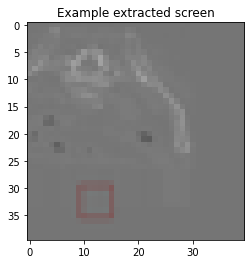

In [7]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

def get_screen():
    # Returned screen requested by gym is 405x405x3, but is sometimes larger
    # Transpose it into torch order (CHW).
    screen = env.render().transpose((2, 0, 1))

    # # Convert to float, rescale, convert to torch tensor
    # # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [8]:
BATCH_SIZE = 32
GAMMA = 0.99
EPS_START = 0.95
EPS_END = 0.15
EPS_DECAY = 500
TARGET_UPDATE = 5

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape
print(init_screen.shape)

# Get number of actions from gym action space
n_actions = env.action_space.n


# # Regular DQN Fully Connected
# policy_net = DQN_Fully_Connected(screen_height, screen_width, n_actions).to(device)
# target_net = DQN_Fully_Connected(screen_height, screen_width, n_actions).to(device)
# target_net.load_state_dict(policy_net.state_dict())
# target_net.eval()
# model_type = "FC-DQN"

# Regular DQN Convnet
policy_net = DQN_Conv(screen_height, screen_width, n_actions).to(device)
target_net = DQN_Conv(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
model_type = "Conv-DQN"

# # # Dueling DQN 
# policy_net = Dueling_DQN(screen_height, screen_width, n_actions).to(device)
# target_net = Dueling_DQN(screen_height, screen_width, n_actions).to(device)
# target_net.load_state_dict(policy_net.state_dict())
# target_net.eval()
# model_type = "Dueling-DQN"


optimizer = optim.RMSprop(policy_net.parameters())#,lr=0.01)

# Adam Optimizer 
#optimizer = optim.Adam(policy_net.parameters(),lr=0.0002)
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

# episode_durations = []

# def plot_durations():
#     plt.figure(2)
#     plt.clf()
#     durations_t = torch.tensor(episode_durations, dtype=torch.float)
#     plt.title('Training...')
#     plt.xlabel('Episode')
#     plt.ylabel('Duration')
#     plt.plot(durations_t.numpy())
#     # Take 100 episode averages and plot them too
#     if len(durations_t) >= 100:
#         means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
#         means = torch.cat((torch.zeros(99), means))
#         plt.plot(means.numpy())

#     plt.pause(0.001)  # pause a bit so that plots are updated
#     if is_ipython:
#         display.clear_output(wait=True)
#         display.display(plt.gcf())

torch.Size([1, 3, 40, 40])


In [9]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

    return loss

In [10]:
# Training Loop
from random import sample
num_episodes = 100
#num_episodes = 5 
training_loss = []
training_reward = []
training_steps = []

# are the coordinate right? 
# The issue is that the image is reshaped, and therefore, the point that we have redefined is not in the correct spot, therefore, we need to make sure that we always use a square image. 
# Coordinates are not quite correct. 

p1 = r'C:\Users\asong18\Desktop\Deep_RL_View_Planning\CT_View_Planning_DeepRL\gym-child_thresholded_NN\FOV_translated\train\001_cropped_grayscale_x82_y47.png'
point1 = (82, 47)

p2 = r'C:\Users\asong18\Desktop\Deep_RL_View_Planning\CT_View_Planning_DeepRL\gym-child_thresholded_NN\FOV_translated\train\001_cropped_grayscale_x82_y230.png'
point2 = (82,230)

p3 = r'C:\Users\asong18\Desktop\Deep_RL_View_Planning\CT_View_Planning_DeepRL\gym-child_thresholded_NN\FOV_translated\train\001_cropped_grayscale_x183_y105.png'
point3 = (183,105)

# p4 = r'C:\Users\asong18\Desktop\Deep_RL_View_Planning\CT_View_Planning_DeepRL\gym-child_thresholded_NN\FOV_translated\train\001_cropped_grayscale_x110_y50.png'
# point4 = (110, 50)

# p5 = r'C:\Users\asong18\Desktop\Deep_RL_View_Planning\CT_View_Planning_DeepRL\gym-child_thresholded_NN\FOV_translated\train\001_cropped_grayscale_x110_y90.png'
# point5 = (110, 90)

# p6 = r'C:\Users\asong18\Desktop\Deep_RL_View_Planning\CT_View_Planning_DeepRL\gym-child_thresholded_NN\FOV_translated\train\001_cropped_grayscale_x155_y65.png'
# point6 = (155,65)

environments = [p1, p2, p3]#, p4, p5, p6]
coordinates = [point1, point2, point3]#, point4, point5, point6]

for i_episode in range(num_episodes):

    # if we doing different field of views.
    num = random.randint(0,2) 
    env.set_background_env(environments[num])
    target_coordinates = coordinates[num]
    env.set_target_xy(x = target_coordinates[0], y = target_coordinates[1])

    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen

    episode_loss = 0.0
    episode_reward = 0.0
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        
        episode_reward+= reward.item()

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        
        step_loss = optimize_model()
        if step_loss is not None:
            episode_loss += step_loss.item()
        
        if done:
            # episode_durations.append(t + 1)
            # plot_durations()
            training_steps.append(t+1)
            
            if episode_loss is not None:
                training_loss.append(episode_loss)
            
            training_reward.append(episode_reward)

            print(f"Just finished Episode {i_episode} in {t+1} steps, with reward {episode_reward}!")
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

# save model. 
torch.save(policy_net.state_dict(), f"{model_type}_policy_network_gymTEEN_{num_episodes}episodes.pkl")
# save model. 
torch.save(target_net.state_dict(), f"{model_type}_target_network_gymTEEN_{num_episodes}episodes.pkl")


The path is actually set
New background Set!
set the target x to 183
set the target y to 105
(189, 101)
current distance is: 15.231546211727817, and future distance is 7.211102550927978
the stepsize has decreased and is now 5
Just finished Episode 0 in 55 steps, with reward 7.0!
The path is actually set
New background Set!
set the target x to 82
set the target y to 230
(88, 225)
current distance is: 16.76305461424021, and future distance is 7.810249675906654
the stepsize has decreased and is now 5
Just finished Episode 1 in 199 steps, with reward 8.0!
The path is actually set
New background Set!
set the target x to 183
set the target y to 105
(190, 110)
current distance is: 16.55294535724685, and future distance is 8.602325267042627
Just finished Episode 2 in 210 steps, with reward 24.0!
The path is actually set
New background Set!
set the target x to 82
set the target y to 47
(76, 47)
current distance is: 11.661903789690601, and future distance is 6.0
Just finished Episode 3 in 172 st

In [12]:
# Testing Loop 
num_episodes = 50
testing_reward = []
testing_steps = []

p1 = r'C:\Users\asong18\Desktop\Deep_RL_View_Planning\CT_View_Planning_DeepRL\gym-child_thresholded_NN\FOV_translated\test\001_cropped_grayscale_x273_y190.png'
point1 = (273, 190)

p2 = r'C:\Users\asong18\Desktop\Deep_RL_View_Planning\CT_View_Planning_DeepRL\gym-child_thresholded_NN\FOV_translated\test\001_cropped_grayscale_x273_y230.png'
point2 = (273,230)

environments = [p1, p2]
coordinates = [point1, point2]

for i_episode in range(num_episodes):

    # if we doing different field of views.
    num = random.randint(0,1) 
    env.set_background_env(environments[num])
    target_coordinates = coordinates[num]
    env.set_target_xy(x = target_coordinates[0], y = target_coordinates[1])

    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    
    episode_reward = 0.0
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        
        episode_reward+= reward.item()

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state
        
        if done:
            # episode_durations.append(t + 1)
            # plot_durations()
            testing_steps.append(t+1)

            testing_reward.append(episode_reward)

            print(f"Just finished Episode {i_episode} in {t+1} steps, with reward {episode_reward}!")
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()


The path is actually set
New background Set!
set the target x to 273
set the target y to 190
Just finished Episode 0 in 10000 steps, with reward -4.0!
The path is actually set
New background Set!
set the target x to 273
set the target y to 190


KeyboardInterrupt: 

In [ ]:
# # Test on Same centered spot
# test_episodes = 100
# total_test_steps = 0
# test_num_steps = []
# for i_episode in range(test_episodes):
#     # Initialize the environment and state
#     env.reset()
#     last_screen = get_screen()
#     current_screen = get_screen()
#     state = current_screen - last_screen

#     for t in count():
#         # Select and perform an action
#         action = select_action(state)
#         _, reward, done, _ = env.step(action.item())
#         reward = torch.tensor([reward], device=device)
        

#         # Observe new state
#         last_screen = current_screen
#         current_screen = get_screen()
#         if not done:
#             next_state = current_screen - last_screen
#         else:
#             next_state = None


#         # Move to the next state
#         state = next_state
        
#         if done:
#             test_num_steps.append(t+1)
#             total_test_steps +=t+1

#             print(f"Just finished Episode {i_episode} in {t+1} steps!")
#             break

# print(f"Average Testing Steps for 100 episodes is {total_test_steps / test_episodes}")


# print('Complete')
# env.render()
# env.close()
# plt.ioff()
# plt.show()

In [ ]:
# # #### Translated and ROTATED
# test_episodes = 100
# total_test_steps = 0
# test_num_steps = []
# trans_rot = 'bottom_left'
# background_path = r'./z_top_right.png'
# env.set_background_env(background_path)
# for i_episode in range(test_episodes):
#     # Initialize the environment and state
#     env.reset()
#     last_screen = get_screen()
#     current_screen = get_screen()
#     state = current_screen - last_screen

#     for t in count():
#         # Select and perform an action
#         action = select_action(state)
#         _, reward, done, _ = env.step(action.item())
#         reward = torch.tensor([reward], device=device)
        

#         # Observe new state
#         last_screen = current_screen
#         current_screen = get_screen()
#         if not done:
#             next_state = current_screen - last_screen
#         else:
#             next_state = None


#         # Move to the next state
#         state = next_state
        
#         if done:
#             test_num_steps.append(t+1)
#             total_test_steps +=t+1

#             print(f"Just finished Episode {i_episode} in {t+1} steps!")
#             break

# print(f"Average Testing Steps for 100 episodes is {total_test_steps / test_episodes}")


# print('Complete')
# env.render()
# env.close()
# plt.ioff()
# plt.show()

In [ ]:
import pickle
# pickle save 
with open(f'001_{model_type}_{num_episodes}_{environment_type}_graph.pkl', 'wb') as f:
    pickle.dump(training_steps, f)

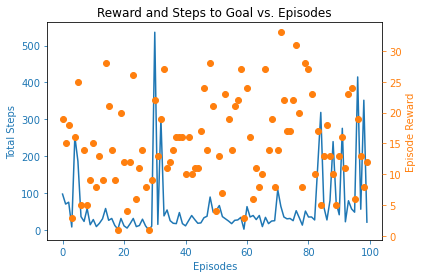

In [ ]:
import matplotlib.pyplot as plt
# length = len(fit.history['nb_episode_steps'])
length = num_episodes
fig = plt.figure()
#plt.title("Reward and Steps to Goal vs. Episodes")
ax = fig.add_subplot(111, label="1")
ax2 = fig.add_subplot(111, label="2", frame_on=False)
ax.plot(range(length), training_steps, color="C0")
ax.set_xlabel("Episodes", color="C0")
ax.set_ylabel("Total Steps", color="C0")
ax.tick_params(axis='x', colors="C0")
ax.tick_params(axis='y', colors="C0")
ax2.scatter(range(length), training_reward, color="C1")
ax2.axes.get_xaxis().set_visible(False)
ax2.yaxis.tick_right()
ax2.set_ylabel('Episode Reward', color="C1")
ax2.yaxis.set_label_position('right')
ax2.tick_params(axis='y', colors="C1")
ax.set_title("Reward and Steps to Goal vs. Episodes")
fig.savefig(f"Grayscale_{model_type}_{length}eps_{environment_type}")
# print(f"Average Testing Steps for 50 episodes is {total_test_steps / test_episodes}")

In [ ]:
l = training_steps
l = np.array(l)
l = l[(l>np.quantile(l,0.1)) & (l<np.quantile(l,0.9))].tolist()
print(f" Average number of testing steps after removing outliers {np.mean(l)}")

 Average number of testing steps after removing outliers 39.294871794871796
